# 2) Comparing KNN and Logistic Regression for Predicting Survival on the Titanic

## 1\. Load and Prepare Data:

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [68]:
df = pd.read_csv('Titanic Survivors.csv')
df.sample
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Explore the data and handle missing values.

In [69]:
df.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [72]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


<Axes: >

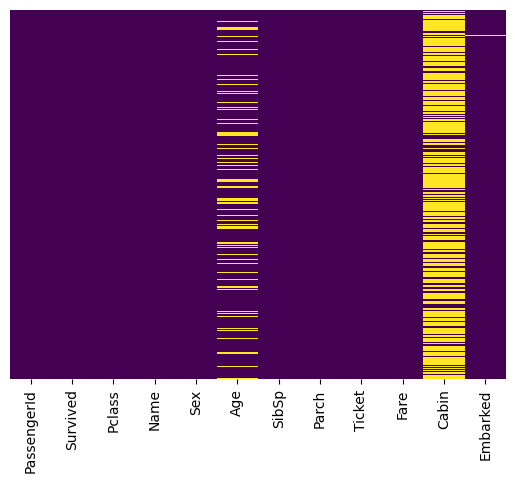

In [73]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [74]:
numerical_column = ['Age']

for col in numerical_column:
    df[col].fillna(df[col].mean(), inplace=True)

categorical_column = ['Cabin', 'Embarked']

for col in categorical_column:
    df[col].fillna(df[col].mode()[0], inplace=True)

<Axes: >

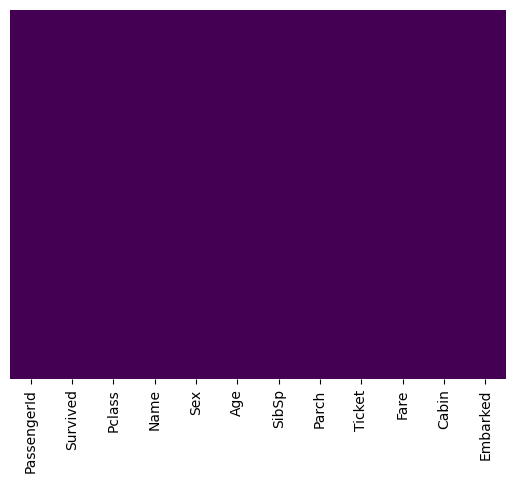

In [75]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Convert categorical variables to numerical ones.

In [76]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

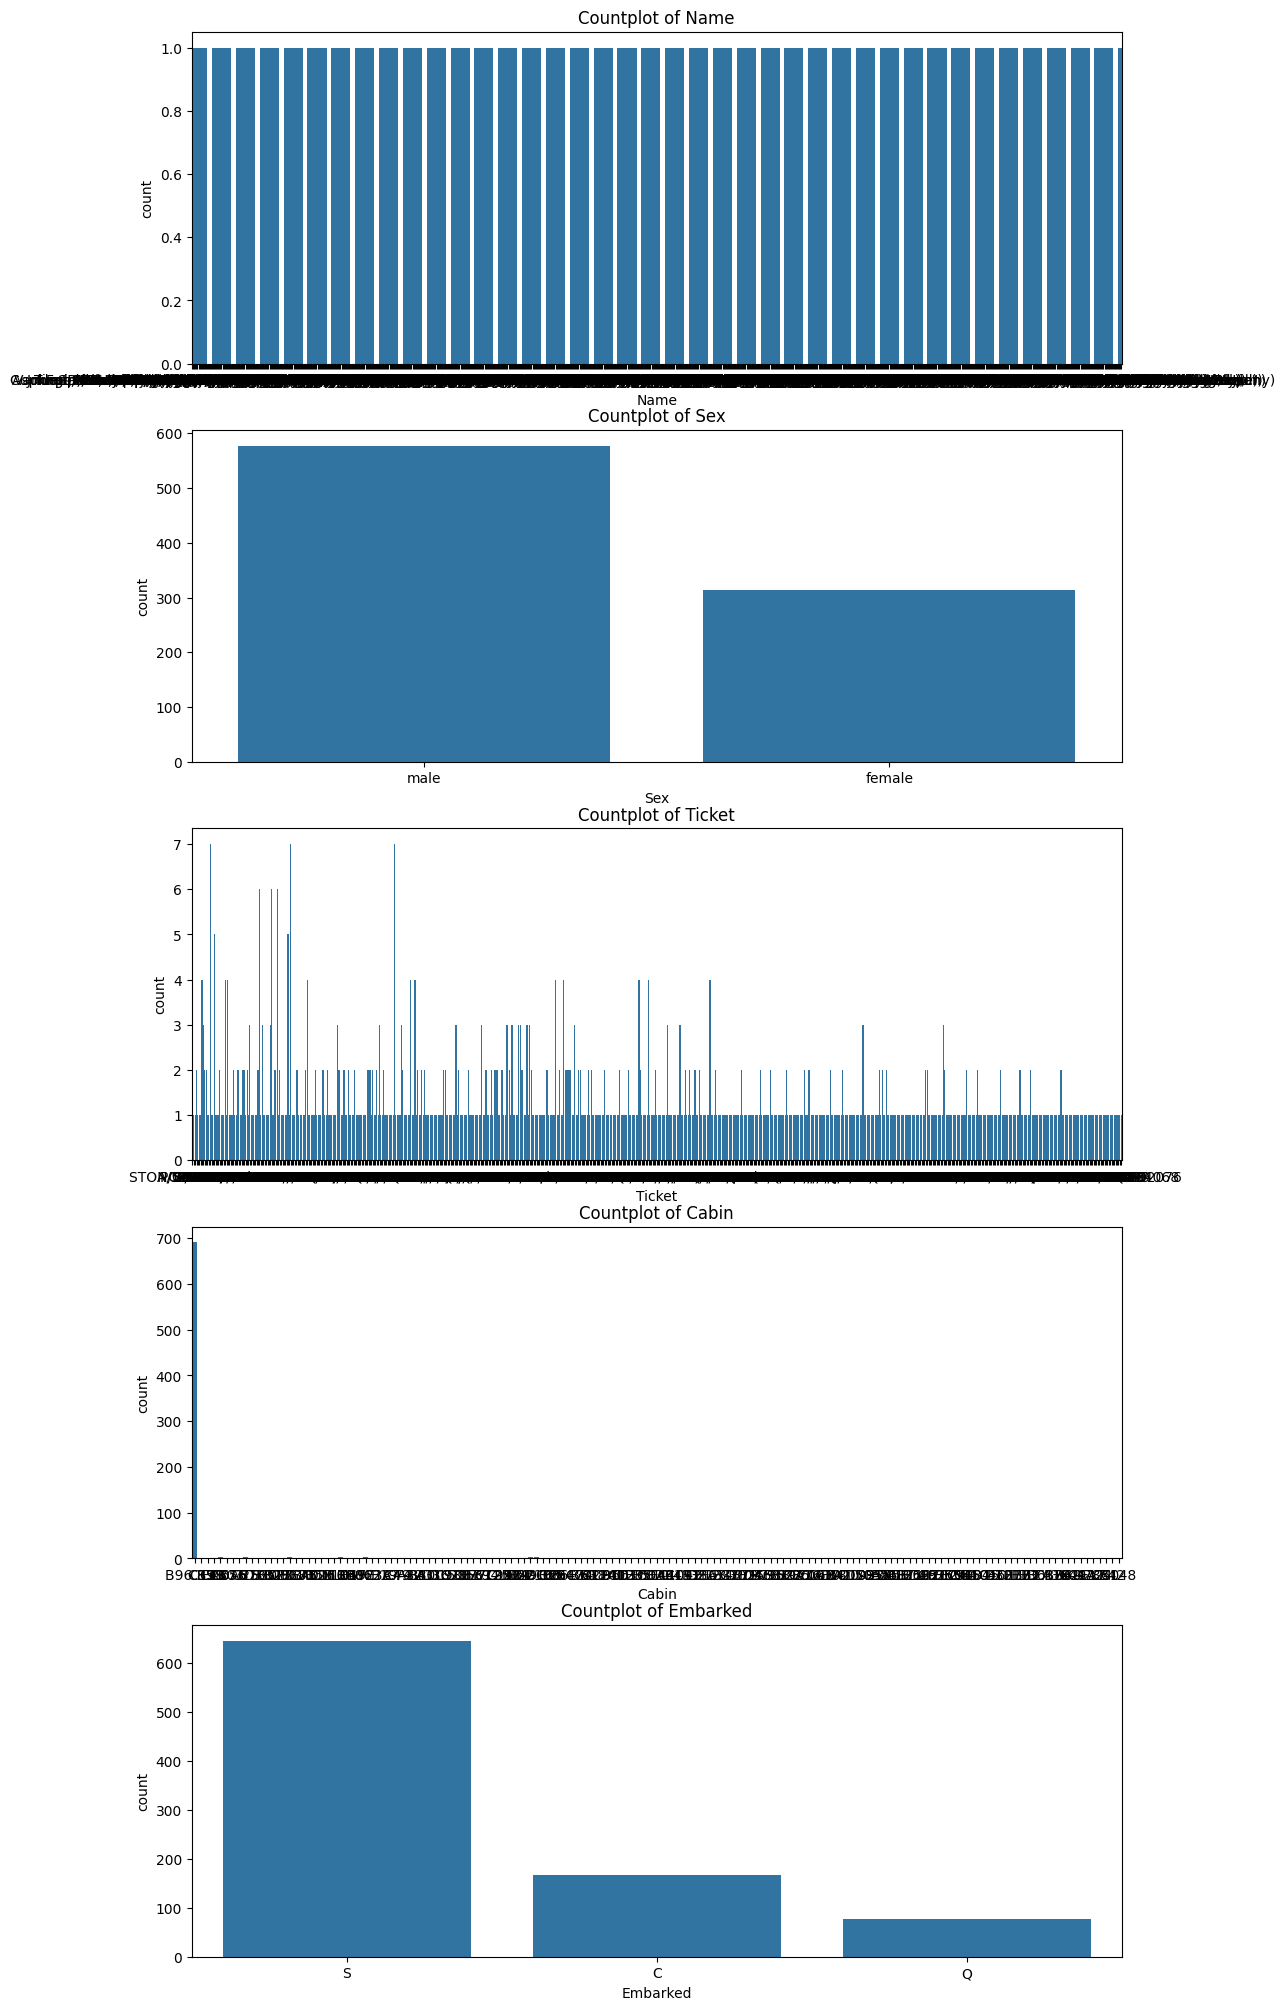

In [77]:
plt.figure(figsize=(12, 25))
for i, col in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)  # Create subplots
    sns.countplot(x=col, data=df)
    plt.title(f'Countplot of {col}')

plt.show()

เนื่องจาก name และ ticket นั้นมีจำนวนของค่าแตกต่างกันมากเกินไป เมื่อทำ label encoding จะทำให้ได้ค่าหลากหลายเกิน จะไม่นำมาใช้ในการทำ KNN รวมถึงค่า PassengerId ที่เราจะต้อง drop ด้วยเนื่องจากทุกคนมี id ที่แตกต่างกัน

In [78]:
df.drop(['PassengerId', 'Name', 'Ticket'],axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Sex', 'Cabin', 'Embarked']
label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.000000,1,0,7.2500,47,2
1,1,1,0,38.000000,1,0,71.2833,81,0
2,1,3,0,26.000000,0,0,7.9250,47,2
3,1,1,0,35.000000,1,0,53.1000,55,2
4,0,3,1,35.000000,0,0,8.0500,47,2
5,0,3,1,29.699118,0,0,8.4583,47,1
6,0,1,1,54.000000,0,0,51.8625,129,2
7,0,3,1,2.000000,3,1,21.0750,47,2
8,1,3,0,27.000000,0,2,11.1333,47,2
9,1,2,0,14.000000,1,0,30.0708,47,0


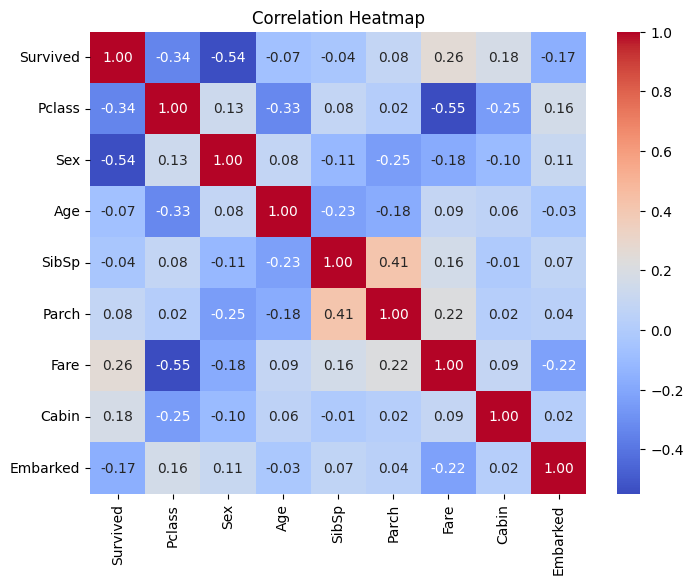

In [79]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Split the data into training and testing sets.

In [80]:
y_df = df[['Survived']]
df.drop(['Survived'],axis=1,inplace=True)
X_df = df
with pd.option_context('display.max_rows', 10): display(X_df)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,7.2500,47,2
1,1,0,38.000000,1,0,71.2833,81,0
2,3,0,26.000000,0,0,7.9250,47,2
3,1,0,35.000000,1,0,53.1000,55,2
4,3,1,35.000000,0,0,8.0500,47,2
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,47,2
887,1,0,19.000000,0,0,30.0000,30,2
888,3,0,29.699118,1,2,23.4500,47,2
889,1,1,26.000000,0,0,30.0000,60,0


In [81]:
X = X_df.values
y = y_df.values

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 2\. Build KNN Model:

### Define the K value (number of neighbors).

In [83]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [84]:
from sklearn.neighbors import KNeighborsClassifier
scores = []
for k in range(1,30):
  neigh = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
  neigh.fit(X_train, y_train.ravel())
  scores.append([k,neigh.score(X_test,y_test)])

In [85]:
scores

[[1, 0.7821229050279329],
 [2, 0.8100558659217877],
 [3, 0.7821229050279329],
 [4, 0.7988826815642458],
 [5, 0.8044692737430168],
 [6, 0.8100558659217877],
 [7, 0.8379888268156425],
 [8, 0.8268156424581006],
 [9, 0.8100558659217877],
 [10, 0.8156424581005587],
 [11, 0.8324022346368715],
 [12, 0.8268156424581006],
 [13, 0.8268156424581006],
 [14, 0.8156424581005587],
 [15, 0.8324022346368715],
 [16, 0.8212290502793296],
 [17, 0.8212290502793296],
 [18, 0.7932960893854749],
 [19, 0.7988826815642458],
 [20, 0.7988826815642458],
 [21, 0.8100558659217877],
 [22, 0.7988826815642458],
 [23, 0.7988826815642458],
 [24, 0.8100558659217877],
 [25, 0.8044692737430168],
 [26, 0.8100558659217877],
 [27, 0.8156424581005587],
 [28, 0.8100558659217877],
 [29, 0.8044692737430168]]

In [86]:
scores.sort(key=lambda x: x[1], reverse=True)
print(f"Best k={scores[0][0]} with accuracy score:{scores[0][1]}")

Best k=7 with accuracy score:0.8379888268156425


### Train the KNN model on the training set.

In [87]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
new = X_test
new = scaler.transform(new)

In [88]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
neigh.fit(X_norm, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=7)

### Predict survival on the testing set.

In [89]:
y_pred = neigh.predict(new)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [90]:
k = scores[0][0]
neigh = KNeighborsClassifier(n_neighbors=7,metric='euclidean')
neigh.fit(X_train, y_train.ravel())

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[92 13]
 [16 58]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       105
           1       0.82      0.78      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



## 3\. Build Logistic Regression Model:

### Define the parameter value

In [92]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, y_train)

print("classes:", model.classes_)
print("features:", X_df.columns.tolist())
print("coef:", model.coef_)
print("intercept:", model.intercept_)

classes: [0 1]
features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
coef: [[-0.72381794 -1.28411645 -0.40208618 -0.35971439 -0.11110979  0.14113707
   0.21976434 -0.18909107]]
intercept: [-0.67863085]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Predict survival on the testing set.

In [93]:
y_predL = model.predict(X_test)
print("survive = 1 , not survive = 0")
print(y_predL)

survive = 1 , not survive = 0
[0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1]


## 4\. Compare Models:

### Calculate performance metrics such as accuracy, precision, recall, and F1-score.

In [94]:
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.8379888268156425

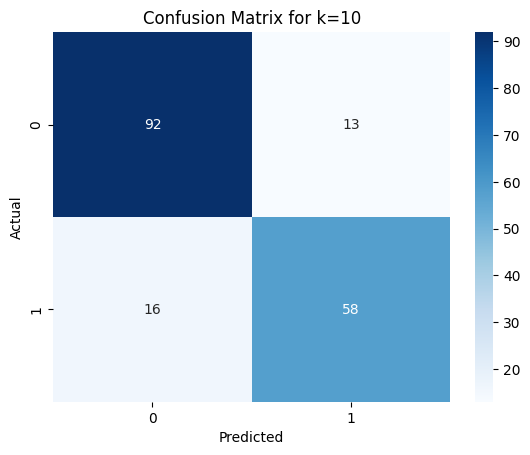

In [95]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for k=10')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       105
           1       0.82      0.78      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



In [97]:
model.score(X_test, y_test)

0.8100558659217877

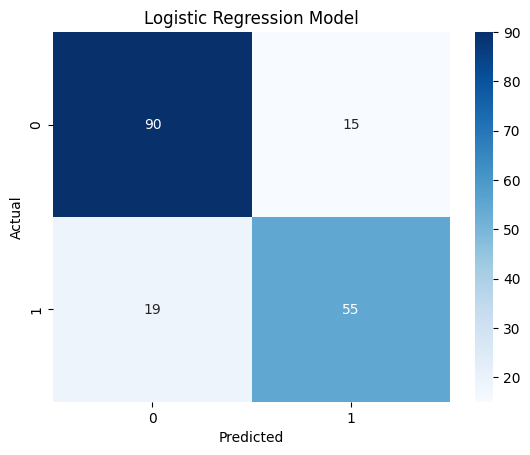

In [98]:
cmL = confusion_matrix(y_test, y_predL)
sns.heatmap(cmL, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [99]:
print(classification_report(y_test, y_predL))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



### Compare the results of KNN and Logistic Regression models.

KNN มี score ที่สูงกว่า Logistic Regression เล็กน้อยคือ 0.8379 กับ 0.8100

## 5\. Explain Results:

### Summarize the findings of both models.

จากการทำ predict 2 แบบสามารถสรุปได้ว่า การทำ prediction แบบ K-NN และแบบ Logistic regression บน Titanic daataset นั้น ได้ผลลัพท์ที่ไม่แตกต่างกันมาก โดย K-NN ได้ผลลัพท์ดีกว่าเล็กน้อย อาจจะเกิดจากข้อมูลมีจำนวนไม่มาก ทำให้ K-NN ให้ผลลัพท์ดีกว่า

### Discuss the advantages and disadvantages of each model.

K-NN  
Advantages

* ทำได้ง่ายและ implement ให้เข้าใจได้ง่าย
* ใช้ได้กับ dataset หลากหลายแบบ
* เลือกค่า k ที่เหมาะสมกับ dataset จะได้ความแม่นยำมากที่สุด

Disadvantages

* ถ้าเราเลือกใช้ irrelevant attribute มาใช้ในการคำนวณด้วยจะทำให้ผลลัพท์ออกมาไม่ถูกต้อง
* ต้องเลือกใช้ค่า k ที่เหมาะสม ไม่อย่างนั้นค่าที่ได้จะเพี้ยน



Logistic Regression  
Advantages

* เหมาะกับ dataset ที่มีขนาดใหญ่
* เป็น parametric model
* ใช้งานได้ดีสำหรับข้อมูลที่มีหลาย dimension

Disadvantages

* จะใช้ได้ต่อเมื่อมี linear relationship เท่านั้น
* ถ้ามี outlier จะทำให้สมการ logistic regression ให้ค่า predict ที่ไม่ใกล้เคียงกับความเป็นจริง

### Recommend the most suitable model for predicting survival on the Titanic.

K-NN เนื่องจากใช้งานง่าย มีข้อมูลจำนวนไม่มากเกินไป(891 แถว) สามารถเลือกค่า k ที่เหมาะสมได้ง่าย และจากการทำ test/train ได้ผลลัพท์ที่ดีกว่า logisticc regression

